In [5]:
import pandas as pd
import json

# --- 1. Load the original BlueSky trajectory ---
truth = pd.read_csv("bluesky_log_20251029_155904.csv")

# Simplify: only keep utc, lat, lon, alt, id
truth = truth[["utc", "id", "lat", "lon", "alt"]].copy()
truth.head()


,utc,id,lat,lon,alt
0,2025-10-29 00:00:00.250000,MS841,51.429379,4.157741,9753.6
1,2025-10-29 00:00:00.250000,LY620,49.979921,5.682769,9753.6
2,2025-10-29 00:00:00.250000,CX520,50.111320,5.962904,9753.6
3,2025-10-29 00:00:00.250000,HV296,51.759124,5.972137,9753.6
4,2025-10-29 00:00:00.250000,GA653,51.562470,3.772221,9753.6


In [7]:
import json
import pandas as pd

geojson_path = "/home/zzahir2/gnss-sdr/output/pvt.dat_251105_120230.geojson"  # change if your filename differs

with open(geojson_path, "r") as f:
    gj = json.load(f)

# Expect a single Feature with a MultiPoint geometry
assert gj.get("type") == "Feature", "GeoJSON is not a single Feature."
geom = gj.get("geometry", {})
assert geom.get("type") == "MultiPoint", "Geometry is not MultiPoint."

coords = geom["coordinates"]  # list of [lon, lat, alt]
est = pd.DataFrame(coords, columns=["lon", "lat", "alt"])

print("✅ loaded estimated positions:", est.shape)
est.head()


✅ loaded estimated positions: (357, 3)


,lon,lat,alt
0,1.064368e-06,0.000004,-7.136081
1,2.043921e-06,-0.000009,-9.315821
2,-7.100890e-06,0.000002,-7.866289
3,-5.002597e-07,-0.000006,-9.364970
4,-2.345624e-06,-0.000002,-8.193377


In [8]:
import pandas as pd
import re

nmea_path = "/home/zzahir2/gnss-sdr/output/nmea_pvt.nmea"

# Read all NMEA lines
with open(nmea_path) as f:
    lines = [ln.strip() for ln in f if ln.startswith("$GPGGA") or ln.startswith("$GNGGA")]

# Parse time, latitude, longitude, altitude from $GPGGA sentences
records = []
for ln in lines:
    parts = ln.split(',')
    if len(parts) < 10:
        continue
    hhmmss = parts[1]
    lat_raw, lat_dir = parts[2], parts[3]
    lon_raw, lon_dir = parts[4], parts[5]
    alt = parts[9]

    # convert lat/lon from ddmm.mmmm to decimal degrees
    if lat_raw and lon_raw:
        lat = int(lat_raw[:2]) + float(lat_raw[2:]) / 60
        lon = int(lon_raw[:3]) + float(lon_raw[3:]) / 60
        if lat_dir == "S":
            lat = -lat
        if lon_dir == "W":
            lon = -lon
        records.append((hhmmss, lat, lon, float(alt) if alt else None))

nmea = pd.DataFrame(records, columns=["hhmmss", "lat", "lon", "alt"])
print("✅ Parsed", len(nmea), "NMEA fixes")
nmea.head()


✅ Parsed 357 NMEA fixes


,hhmmss,lat,lon,alt
0,000029.00,0.000004,1.065000e-06,-7.136
1,000030.00,-0.000009,2.043333e-06,-9.316
2,000031.00,0.000002,-7.101667e-06,-7.866
3,000032.00,-0.000006,-5.000000e-07,-9.365
4,000033.00,-0.000002,-2.345000e-06,-8.193


In [9]:
import pandas as pd

# --- 1) Convert hhmmss to datetime ---
# Extract hour, minute, second from hhmmss string
def parse_hhmmss(x):
    try:
        h = int(x[0:2])
        m = int(x[2:4])
        s = float(x[4:])
        return pd.Timestamp(year=2025, month=10, day=29, hour=h, minute=m, second=int(s))
    except:
        return pd.NaT

nmea["utc"] = nmea["hhmmss"].apply(parse_hhmmss)
nmea = nmea.dropna(subset=["utc"]).sort_values("utc").reset_index(drop=True)

print("✅ NMEA timestamps parsed:", len(nmea))
nmea.head()


✅ NMEA timestamps parsed: 357


,hhmmss,lat,lon,alt,utc
0,000029.00,0.000004,1.065000e-06,-7.136,2025-10-29 00:00:29
1,000030.00,-0.000009,2.043333e-06,-9.316,2025-10-29 00:00:30
2,000031.00,0.000002,-7.101667e-06,-7.866,2025-10-29 00:00:31
3,000032.00,-0.000006,-5.000000e-07,-9.365,2025-10-29 00:00:32
4,000033.00,-0.000002,-2.345000e-06,-8.193,2025-10-29 00:00:33


In [11]:
import pandas as pd

# 1) Normalize truth UTC (handles mixed formats with/without microseconds)
truth2 = truth.copy()
truth2["utc"] = pd.to_datetime(truth2["utc"], format="mixed", errors="coerce")
truth2 = truth2.dropna(subset=["utc"]).sort_values("utc").reset_index(drop=True)

# 2) Ensure NMEA UTC is datetime (it should already be from parse_hhmmss; this enforces it)
nmea2 = nmea.copy()
nmea2["utc"] = pd.to_datetime(nmea2["utc"], errors="coerce")
nmea2 = nmea2.dropna(subset=["utc"]).sort_values("utc").reset_index(drop=True)

# 3) Nearest-time merge
merged = pd.merge_asof(
    nmea2, truth2, on="utc", direction="nearest",
    suffixes=("_est", "_truth")
)

print("✅ merged rows:", len(merged))
merged.head()


✅ merged rows: 357


,hhmmss,lat_est,lon_est,alt_est,utc,id,lat_truth,lon_truth,alt_truth
0,000029.00,0.000004,1.065000e-06,-7.136,2025-10-29 00:00:29,AZ087,52.88778,6.191326,10668.0
1,000030.00,-0.000009,2.043333e-06,-9.316,2025-10-29 00:00:30,AZ087,52.88778,6.191326,10668.0
2,000031.00,0.000002,-7.101667e-06,-7.866,2025-10-29 00:00:31,AZ087,52.88778,6.191326,10668.0
3,000032.00,-0.000006,-5.000000e-07,-9.365,2025-10-29 00:00:32,AZ087,52.88778,6.191326,10668.0
4,000033.00,-0.000002,-2.345000e-06,-8.193,2025-10-29 00:00:33,AZ087,52.88778,6.191326,10668.0


In [12]:
import numpy as np

R = 6371000.0  # Earth radius (m)

lat1 = np.radians(merged["lat_truth"])
lat2 = np.radians(merged["lat_est"])
dlon = np.radians(merged["lon_est"] - merged["lon_truth"])
dlat = lat2 - lat1

a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
merged["pos_error_m"] = 2 * R * np.arcsin(np.sqrt(a))

print("✅ position errors computed (m):")
merged[["utc", "id", "lat_truth", "lon_truth", "lat_est", "lon_est", "pos_error_m"]].head()


✅ position errors computed (m):


,utc,id,lat_truth,lon_truth,lat_est,lon_est,pos_error_m
0,2025-10-29 00:00:29,AZ087,52.88778,6.191326,0.000004,1.065000e-06,5.908922e+06
1,2025-10-29 00:00:30,AZ087,52.88778,6.191326,-0.000009,2.043333e-06,5.908924e+06
2,2025-10-29 00:00:31,AZ087,52.88778,6.191326,0.000002,-7.101667e-06,5.908922e+06
3,2025-10-29 00:00:32,AZ087,52.88778,6.191326,-0.000006,-5.000000e-07,5.908923e+06
4,2025-10-29 00:00:33,AZ087,52.88778,6.191326,-0.000002,-2.345000e-06,5.908923e+06


In [14]:
!pip install folium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [folium]


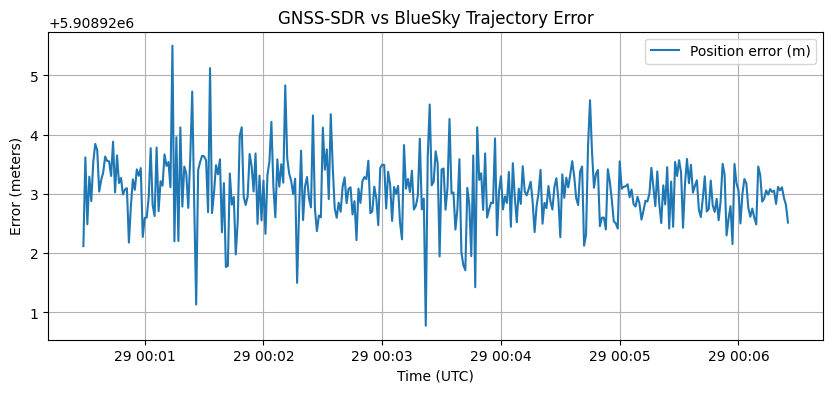

In [15]:
import matplotlib.pyplot as plt
import folium

# --- 1) Plot horizontal error vs time ---
plt.figure(figsize=(10,4))
plt.plot(merged["utc"], merged["pos_error_m"], label="Position error (m)")
plt.xlabel("Time (UTC)")
plt.ylabel("Error (meters)")
plt.title("GNSS-SDR vs BlueSky Trajectory Error")
plt.grid(True)
plt.legend()
plt.show()

# --- 2) Interactive map: truth vs estimate ---
# center map roughly on the truth start point
m = folium.Map(location=[merged["lat_truth"].iloc[0],
                         merged["lon_truth"].iloc[0]], zoom_start=13)

# truth path (blue)
folium.PolyLine(list(zip(merged["lat_truth"], merged["lon_truth"])),
                color="blue", weight=3, opacity=0.7, tooltip="BlueSky truth").add_to(m)

# estimated path (red)
folium.PolyLine(list(zip(merged["lat_est"], merged["lon_est"])),
                color="red", weight=2, opacity=0.7, tooltip="GNSS-SDR estimate").add_to(m)

m
